## Cab-Driver Agent - Reinforcement Learning Project

### Problem Statement
* You are hired as a Sr. Machine Learning Er. at SuperCabs, a leading app-based cab provider in a large Indian metro city. In this highly competitive industry, retention of good cab drivers is a crucial business driver, and you believe that a sound RL-based system for assisting cab drivers can potentially retain and attract new cab drivers. 

* Cab drivers, like most people, are incentivised by a healthy growth in income. The goal of your project is to build an RL-based algorithm which can help cab drivers maximise their profits by improving their decision-making process on the field.

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

Using TensorFlow backend.


#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [3]:
print(Time_matrix)

[[[[ 0.  0.  0. ...  0.  0.  0.]
   [ 0.  0.  0. ...  0.  0.  0.]
   [ 0.  0.  0. ...  0.  0.  0.]
   ...
   [ 0.  0.  0. ...  0.  0.  0.]
   [ 0.  0.  0. ...  0.  0.  0.]
   [ 0.  0.  0. ...  0.  0.  0.]]

  [[ 2.  3.  3. ...  7.  0.  6.]
   [ 2.  3.  3. ...  7.  0.  6.]
   [ 2.  3.  3. ...  7.  0.  6.]
   ...
   [ 2.  3.  6. ...  7.  4.  2.]
   [ 2.  3.  6. ...  7.  4.  2.]
   [ 2.  3.  6. ...  7.  4.  2.]]

  [[ 2.  6.  5. ...  3.  7.  7.]
   [ 2.  6.  5. ...  3.  7.  7.]
   [ 2.  6.  5. ...  3.  7.  7.]
   ...
   [ 6.  2.  8. ...  4.  5.  5.]
   [ 6.  2.  8. ...  4.  5.  5.]
   [ 6.  2.  8. ...  4.  5.  5.]]

  [[10.  6.  8. ...  7.  4.  6.]
   [10.  6.  8. ...  7.  4.  6.]
   [10.  6.  8. ...  7.  4.  6.]
   ...
   [ 0.  1.  2. ...  1.  3.  3.]
   [ 0.  1.  2. ...  1.  3.  3.]
   [ 0.  1.  2. ...  1.  3.  3.]]

  [[ 1.  1.  1. ...  1.  1.  1.]
   [ 1.  1.  1. ...  1.  1.  1.]
   [ 1.  1.  1. ...  1.  1.  1.]
   ...
   [ 6.  4.  7. ...  3.  1.  8.]
   [ 6.  4.  7. ...  3.  1.  8.]


In [4]:
print("Time Matrix Type ------",type(Time_matrix))
print("Time Matrix Maximum --- ",Time_matrix.max())
print("Time Matrix Minimun --- ",Time_matrix.min())
print("Time Matrix Mean ------ ",Time_matrix.mean())

Time Matrix Type ------ <class 'numpy.ndarray'>
Time Matrix Maximum ---  11.0
Time Matrix Minimun ---  0.0
Time Matrix Mean ------  3.0542857142857143


#### Tracking the state-action pairs for checking convergence

In [5]:
StatesTrack = collections.defaultdict(dict)
print(StatesTrack)
print("Length of states track",len(StatesTrack))

defaultdict(<class 'dict'>, {})
Length of states track 0


In [6]:
# State Initialisation - State and Action spaces are defined
def StateInitialisation():
    Q_Values_Sample=[((0, 0, 0), (0,1)), ((0, 0, 0), (0,2))]    
    for q_values in Q_Values_Sample:
        state = q_values[0]
        action = q_values[1]
        StatesTrack[state][action] = []

In [7]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [8]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01
        self.epsilon = 1
        self.epsilon_max = 1
        self.epsilon_decay = -0.0003
        self.epsilon_min = 0.00001
        
        self.batch_size = 32

        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # Initialize the value of the states tracked
        self.states_tracked = []
        
        # We are going to track state [0,0,0] and action (0,2) at index 2 in the action space.
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        """
        Function that takes in the agent and constructs the network
        to train it
        @return model
        @params agent
        """
        input_shape = self.state_size
        model = Sequential()
        # Write your code here: Add layers to your neural nets
        
        #Model Hidden Layer
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform')) # Hidden Layer
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform')) # Hidden Layer
        
        # The output layer = Size of num actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform')) # Output layer
        
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate)) #Compiler
        model.summary #Model Summary
        
        return model

    def get_action(self, state, possible_actions_index, actions):
        # Write your code here:
        # get action in a state according to an epsilon-greedy approach
        # get action - epsilon-greedy policy
        #  Decay in ε after we generate each sample from the environment   
        if np.random.rand() <= self.epsilon:
            # Chossing random from possible actions and for cartpole it will choose randomly between 0 and 1
            return random.choice(possible_actions_index)
        else:
            # Choosing action - highest q(s, a)
            # First index corresponds to the batch size
            # Reshape starte to 1,state size - First index corresponds to batch size
            state = np.array(env.state_encod_arch1(state)).reshape(1, 36)

            # Predict Q Values
            q_value = self.model.predict(state)

            # Truncating array part of the request
            q_vals_possible = [q_value[0][i] for i in possible_actions_index]

            return possible_actions_index[np.argmax(q_vals_possible)]

    def append_sample(self, state, action_index, reward, next_state, Terminal_State):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action_index, reward, next_state, Terminal_State))
        
    # pick samples randomly from replay memory (with batch_size) and train the network
    # Function to train model
    def train_model(self):
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            #Creating matrix to update input
            update_input = np.zeros((self.batch_size, self.state_size))
            #Creating matrix to update output
            update_output = np.zeros((self.batch_size, self.state_size))
            
            actions, rewards, Terminal_State = [], [], []

            # Populating below values
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                update_input[i] = env.state_encod_arch1(state)     
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state)
                Terminal_State.append(done_boolean)

            # Write your code from here
            # predict the target q-values from states s
            target = self.model.predict(update_input)
            
            # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)

            # 3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                if Terminal_State[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
                    
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            
    def SaveTrackingStatus_QValue(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_tracked.append(q_value[0][2])
      
    # Q values of the state that we are tracking
    def save_test_states(self):
        q_value = self.model.predict(self.track_state) # Track Q-Value for state 0,0,0 and action 0,2   
        # Q_value of the action index
        self.states_test.append(q_value[0][2])

    def save(self, name):
        with open(name, 'wb') as file:  
            pickle.dump(self.model, file,pickle.HIGHEST_PROTOCOL)

In [9]:
Episodes = 15000

In [10]:
episode_time = 24*30 #30 days before car has to be recharged
m = 5
t = 24
d = 7
#Environment class
env = CabDriver()
action_space, state_space, state = env.reset()
#Setting up state size and action size
state_size = m+t+d
action_size = len(action_space)
# Agent Class
agent = DQNAgent(action_size=action_size, state_size=state_size)
# Storing rewardds in each episode
Rewards_Each_Episodes, episodes = [], []
# [0,0,0] rewards tracking
rewards_init_state = []

### DQN block

In [11]:
start_time = time.time()
score_tracked = []

for episode in range(Episodes):

    Terminal_State = False
    score = 0
    track_reward = False

    env = CabDriver() # Resetting at each episode start
    action_space, state_space, state = env.reset()
    initial_state = env.state_init # Saving intial state to track [0,0,0] Reward
    total_time = 0 # Total ride time
    while not Terminal_State:
        #List of request driver received
        possible_actions_indices, actions = env.requests(state)
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action = agent.get_action(state, possible_actions_indices, actions)

        # 2. Evaluate your reward and next state
        reward, next_state, step_time = env.step(state, env.action_space[action], Time_matrix)

        total_time += step_time
        if (total_time > episode_time):
            Terminal_State = True
        else:
            # 3. Append the experience to the memory
            agent.append_sample(state, action, reward, next_state, Terminal_State)
            # 4. Train the model by calling function agent.train_model
            agent.train_model()
            # 5. Keep a track of rewards, Q-values, loss
            score += reward
            state = next_state

    # store total reward obtained in this episode
    Rewards_Each_Episodes.append(score)
    episodes.append(episode)
    
    # Epsilon decay method
    agent.epsilon = (1 - 0.00001) * np.exp(agent.epsilon_decay * episode)

    # Every 10th episodes:
    if ((episode + 1) % 10 == 0):
        print("Episode {0}, Reward {1}, Length of Memory {2}, Epsilon {3} Total Time {4}".format(episode,score,len(agent.memory),agent.epsilon, total_time))
    # Saving QValues and Action pair
    if ((episode + 1) % 5 == 0):
        agent.SaveTrackingStatus_QValue()

    # Total rewards per episode
    score_tracked.append(score)

    if(episode % 1000 == 0):
        print("Saving Model {}".format(episode))
        agent.save(name="DQN_Model.pkl")
    
elapsed_time = time.time() - start_time
print(elapsed_time)

Saving Model 0
Episode 9, Reward 121.0, Length of Memory 1397, Epsilon 0.997293668685296 Total Time 722.0
Episode 19, Reward -165.0, Length of Memory 2000, Epsilon 0.9943062710162915 Total Time 728.0
Episode 29, Reward -34.0, Length of Memory 2000, Epsilon 0.9913278221104378 Total Time 723.0
Episode 39, Reward -150.0, Length of Memory 2000, Epsilon 0.9883582951616745 Total Time 725.0
Episode 49, Reward -119.0, Length of Memory 2000, Epsilon 0.9853976634442391 Total Time 726.0
Episode 59, Reward -277.0, Length of Memory 2000, Epsilon 0.9824459003124261 Total Time 723.0
Episode 69, Reward -218.0, Length of Memory 2000, Epsilon 0.9795029792003475 Total Time 725.0
Episode 79, Reward -90.0, Length of Memory 2000, Epsilon 0.9765688736216932 Total Time 721.0
Episode 89, Reward -225.0, Length of Memory 2000, Epsilon 0.9736435571694934 Total Time 722.0
Episode 99, Reward -176.0, Length of Memory 2000, Epsilon 0.9707270035158803 Total Time 729.0
Episode 109, Reward -238.0, Length of Memory 2000,

Episode 889, Reward 185.0, Length of Memory 2000, Epsilon 0.7658951488174691 Total Time 724.0
Episode 899, Reward 79.0, Length of Memory 2000, Epsilon 0.7636009064552416 Total Time 721.0
Episode 909, Reward 392.0, Length of Memory 2000, Epsilon 0.7613135365063265 Total Time 730.0
Episode 919, Reward 380.0, Length of Memory 2000, Epsilon 0.7590330183843786 Total Time 726.0
Episode 929, Reward 159.0, Length of Memory 2000, Epsilon 0.7567593315647199 Total Time 725.0
Episode 939, Reward 289.0, Length of Memory 2000, Epsilon 0.7544924555841535 Total Time 728.0
Episode 949, Reward 182.0, Length of Memory 2000, Epsilon 0.7522323700407799 Total Time 721.0
Episode 959, Reward 271.0, Length of Memory 2000, Epsilon 0.7499790545938143 Total Time 723.0
Episode 969, Reward 258.0, Length of Memory 2000, Epsilon 0.7477324889634025 Total Time 725.0
Episode 979, Reward 182.0, Length of Memory 2000, Epsilon 0.7454926529304385 Total Time 725.0
Episode 989, Reward 438.0, Length of Memory 2000, Epsilon 0.7

Episode 1759, Reward 639.0, Length of Memory 2000, Epsilon 0.5899544195598481 Total Time 723.0
Episode 1769, Reward -26.0, Length of Memory 2000, Epsilon 0.5881872084432516 Total Time 727.0
Episode 1779, Reward 646.0, Length of Memory 2000, Epsilon 0.5864252910155012 Total Time 726.0
Episode 1789, Reward 387.0, Length of Memory 2000, Epsilon 0.5846686514193286 Total Time 723.0
Episode 1799, Reward 513.0, Length of Memory 2000, Epsilon 0.5829172738449651 Total Time 723.0
Episode 1809, Reward 351.0, Length of Memory 2000, Epsilon 0.5811711425300009 Total Time 721.0
Episode 1819, Reward 422.0, Length of Memory 2000, Epsilon 0.5794302417592424 Total Time 721.0
Episode 1829, Reward 676.0, Length of Memory 2000, Epsilon 0.577694555864571 Total Time 729.0
Episode 1839, Reward 513.0, Length of Memory 2000, Epsilon 0.5759640692248017 Total Time 722.0
Episode 1849, Reward 911.0, Length of Memory 2000, Epsilon 0.5742387662655432 Total Time 723.0
Episode 1859, Reward 814.0, Length of Memory 2000, 

C:\Users\psivasubrama\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118493). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


Episode 2369, Reward 743.0, Length of Memory 2000, Epsilon 0.4912952539458007 Total Time 726.0
Episode 2379, Reward 372.0, Length of Memory 2000, Epsilon 0.4898235768034345 Total Time 721.0
Episode 2389, Reward 644.0, Length of Memory 2000, Epsilon 0.4883563080765659 Total Time 727.0
Episode 2399, Reward 576.0, Length of Memory 2000, Epsilon 0.48689343455976636 Total Time 727.0
Episode 2409, Reward 431.0, Length of Memory 2000, Epsilon 0.4854349430871644 Total Time 726.0
Episode 2419, Reward 751.0, Length of Memory 2000, Epsilon 0.4839808205323269 Total Time 722.0
Episode 2429, Reward 924.0, Length of Memory 2000, Epsilon 0.4825310538081411 Total Time 721.0
Episode 2439, Reward 642.0, Length of Memory 2000, Epsilon 0.4810856298666966 Total Time 723.0
Episode 2449, Reward 621.0, Length of Memory 2000, Epsilon 0.47964453569916826 Total Time 733.0
Episode 2459, Reward 432.0, Length of Memory 2000, Epsilon 0.47820775833569884 Total Time 730.0
Episode 2469, Reward 782.0, Length of Memory 20

Episode 3229, Reward 1050.0, Length of Memory 2000, Epsilon 0.37957237075528805 Total Time 727.0
Episode 3239, Reward 519.0, Length of Memory 2000, Epsilon 0.3784353600118952 Total Time 721.0
Episode 3249, Reward 829.0, Length of Memory 2000, Epsilon 0.3773017551892969 Total Time 723.0
Episode 3259, Reward 1245.0, Length of Memory 2000, Epsilon 0.37617154608504205 Total Time 723.0
Episode 3269, Reward 1034.0, Length of Memory 2000, Epsilon 0.3750447225272412 Total Time 724.0
Episode 3279, Reward 1061.0, Length of Memory 2000, Epsilon 0.3739212743744746 Total Time 723.0
Episode 3289, Reward 1202.0, Length of Memory 2000, Epsilon 0.37280119151570135 Total Time 728.0
Episode 3299, Reward 798.0, Length of Memory 2000, Epsilon 0.3716844638701681 Total Time 725.0
Episode 3309, Reward 918.0, Length of Memory 2000, Epsilon 0.37057108138731865 Total Time 725.0
Episode 3319, Reward 792.0, Length of Memory 2000, Epsilon 0.369461034046703 Total Time 726.0
Episode 3329, Reward 1445.0, Length of Mem

Episode 4089, Reward 581.0, Length of Memory 2000, Epsilon 0.2932558038850587 Total Time 729.0
Episode 4099, Reward 401.0, Length of Memory 2000, Epsilon 0.2923773548058591 Total Time 729.0
Episode 4109, Reward 1082.0, Length of Memory 2000, Epsilon 0.2915015371248262 Total Time 724.0
Episode 4119, Reward 899.0, Length of Memory 2000, Epsilon 0.29062834295959505 Total Time 724.0
Episode 4129, Reward 991.0, Length of Memory 2000, Epsilon 0.2897577644514123 Total Time 721.0
Episode 4139, Reward 932.0, Length of Memory 2000, Epsilon 0.2888897937650655 Total Time 722.0
Episode 4149, Reward 626.0, Length of Memory 2000, Epsilon 0.28802442308881265 Total Time 721.0
Episode 4159, Reward 1338.0, Length of Memory 2000, Epsilon 0.2871616446343117 Total Time 722.0
Episode 4169, Reward 986.0, Length of Memory 2000, Epsilon 0.28630145063655077 Total Time 729.0
Episode 4179, Reward 615.0, Length of Memory 2000, Epsilon 0.28544383335377815 Total Time 722.0
Episode 4189, Reward 779.0, Length of Memory

Episode 4949, Reward 1194.0, Length of Memory 2000, Epsilon 0.2265680358692807 Total Time 722.0
Episode 4959, Reward 828.0, Length of Memory 2000, Epsilon 0.2258893502990423 Total Time 727.0
Episode 4969, Reward 798.0, Length of Memory 2000, Epsilon 0.22521269773448135 Total Time 722.0
Episode 4979, Reward 1026.0, Length of Memory 2000, Epsilon 0.22453807208572027 Total Time 730.0
Episode 4989, Reward 626.0, Length of Memory 2000, Epsilon 0.2238654672811235 Total Time 729.0
Episode 4999, Reward 1044.0, Length of Memory 2000, Epsilon 0.2231948772672434 Total Time 730.0
Saving Model 5000
Episode 5009, Reward 929.0, Length of Memory 2000, Epsilon 0.22252629600876522 Total Time 726.0
Episode 5019, Reward 900.0, Length of Memory 2000, Epsilon 0.22185971748845323 Total Time 721.0
Episode 5029, Reward 676.0, Length of Memory 2000, Epsilon 0.22119513570709615 Total Time 728.0
Episode 5039, Reward 747.0, Length of Memory 2000, Epsilon 0.22053254468345354 Total Time 730.0
Episode 5049, Reward 13

Episode 5809, Reward 1305.0, Length of Memory 2000, Epsilon 0.1750453842604377 Total Time 729.0
Episode 5819, Reward 1052.0, Length of Memory 2000, Epsilon 0.1745210350247718 Total Time 721.0
Episode 5829, Reward 1053.0, Length of Memory 2000, Epsilon 0.17399825647959907 Total Time 722.0
Episode 5839, Reward 819.0, Length of Memory 2000, Epsilon 0.17347704391990917 Total Time 732.0
Episode 5849, Reward 1071.0, Length of Memory 2000, Epsilon 0.1729573926547855 Total Time 726.0
Episode 5859, Reward 1051.0, Length of Memory 2000, Epsilon 0.17243929800736324 Total Time 722.0
Episode 5869, Reward 1062.0, Length of Memory 2000, Epsilon 0.17192275531478693 Total Time 721.0
Episode 5879, Reward 1247.0, Length of Memory 2000, Epsilon 0.171407759928169 Total Time 725.0
Episode 5889, Reward 1198.0, Length of Memory 2000, Epsilon 0.1708943072125474 Total Time 730.0
Episode 5899, Reward 1317.0, Length of Memory 2000, Epsilon 0.17038239254684426 Total Time 724.0
Episode 5909, Reward 1308.0, Length o

Episode 6659, Reward 869.0, Length of Memory 2000, Epsilon 0.13564555615535012 Total Time 729.0
Episode 6669, Reward 1013.0, Length of Memory 2000, Epsilon 0.13523922928193932 Total Time 721.0
Episode 6679, Reward 1490.0, Length of Memory 2000, Epsilon 0.13483411956250488 Total Time 728.0
Episode 6689, Reward 1122.0, Length of Memory 2000, Epsilon 0.13443022335105662 Total Time 723.0
Episode 6699, Reward 692.0, Length of Memory 2000, Epsilon 0.13402753701252595 Total Time 721.0
Episode 6709, Reward 851.0, Length of Memory 2000, Epsilon 0.13362605692273313 Total Time 721.0
Episode 6719, Reward 798.0, Length of Memory 2000, Epsilon 0.1332257794683545 Total Time 727.0
Episode 6729, Reward 1184.0, Length of Memory 2000, Epsilon 0.13282670104689043 Total Time 731.0
Episode 6739, Reward 1009.0, Length of Memory 2000, Epsilon 0.13242881806663237 Total Time 724.0
Episode 6749, Reward 1298.0, Length of Memory 2000, Epsilon 0.13203212694663075 Total Time 731.0
Episode 6759, Reward 1347.0, Length

Episode 7509, Reward 1333.0, Length of Memory 2000, Epsilon 0.10511397933988705 Total Time 726.0
Episode 7519, Reward 1083.0, Length of Memory 2000, Epsilon 0.1047991099421161 Total Time 721.0
Episode 7529, Reward 1358.0, Length of Memory 2000, Epsilon 0.10448518373704196 Total Time 721.0
Episode 7539, Reward 1296.0, Length of Memory 2000, Epsilon 0.10417219789932673 Total Time 723.0
Episode 7549, Reward 1173.0, Length of Memory 2000, Epsilon 0.10386014961209578 Total Time 723.0
Episode 7559, Reward 1049.0, Length of Memory 2000, Epsilon 0.10354903606691242 Total Time 727.0
Episode 7569, Reward 1185.0, Length of Memory 2000, Epsilon 0.10323885446375258 Total Time 725.0
Episode 7579, Reward 1494.0, Length of Memory 2000, Epsilon 0.10292960201097977 Total Time 728.0
Episode 7589, Reward 1198.0, Length of Memory 2000, Epsilon 0.10262127592531985 Total Time 722.0
Episode 7599, Reward 1415.0, Length of Memory 2000, Epsilon 0.10231387343183598 Total Time 722.0
Episode 7609, Reward 1410.0, Le

Episode 8359, Reward 1383.0, Length of Memory 2000, Epsilon 0.08145455675681869 Total Time 725.0
Episode 8369, Reward 1116.0, Length of Memory 2000, Epsilon 0.08121055926578287 Total Time 729.0
Episode 8379, Reward 1991.0, Length of Memory 2000, Epsilon 0.08096729267032865 Total Time 723.0
Episode 8389, Reward 933.0, Length of Memory 2000, Epsilon 0.08072475478105495 Total Time 728.0
Episode 8399, Reward 1549.0, Length of Memory 2000, Epsilon 0.08048294341511919 Total Time 722.0
Episode 8409, Reward 1035.0, Length of Memory 2000, Epsilon 0.0802418563962174 Total Time 724.0
Episode 8419, Reward 888.0, Length of Memory 2000, Epsilon 0.08000149155456486 Total Time 722.0
Episode 8429, Reward 1040.0, Length of Memory 2000, Epsilon 0.07976184672687628 Total Time 722.0
Episode 8439, Reward 1350.0, Length of Memory 2000, Epsilon 0.07952291975634664 Total Time 723.0
Episode 8449, Reward 1051.0, Length of Memory 2000, Epsilon 0.07928470849263158 Total Time 723.0
Episode 8459, Reward 1064.0, Leng

Episode 9209, Reward 1743.0, Length of Memory 2000, Epsilon 0.06312047986496605 Total Time 722.0
Episode 9219, Reward 1187.0, Length of Memory 2000, Epsilon 0.06293140218370127 Total Time 725.0
Episode 9229, Reward 1640.0, Length of Memory 2000, Epsilon 0.06274289088548096 Total Time 721.0
Episode 9239, Reward 1545.0, Length of Memory 2000, Epsilon 0.06255494427370213 Total Time 728.0
Episode 9249, Reward 1202.0, Length of Memory 2000, Epsilon 0.062367560656844005 Total Time 725.0
Episode 9259, Reward 1373.0, Length of Memory 2000, Epsilon 0.062180738348452766 Total Time 733.0
Episode 9269, Reward 1311.0, Length of Memory 2000, Epsilon 0.061994475667126375 Total Time 732.0
Episode 9279, Reward 1134.0, Length of Memory 2000, Epsilon 0.06180877093649949 Total Time 721.0
Episode 9289, Reward 1333.0, Length of Memory 2000, Epsilon 0.06162362248522821 Total Time 736.0
Episode 9299, Reward 1056.0, Length of Memory 2000, Epsilon 0.06143902864697525 Total Time 724.0
Episode 9309, Reward 1317.0

Episode 10049, Reward 1296.0, Length of Memory 2000, Epsilon 0.049060060839431714 Total Time 736.0
Episode 10059, Reward 1472.0, Length of Memory 2000, Epsilon 0.048913101206582425 Total Time 724.0
Episode 10069, Reward 1183.0, Length of Memory 2000, Epsilon 0.04876658179197412 Total Time 723.0
Episode 10079, Reward 1369.0, Length of Memory 2000, Epsilon 0.04862050127693113 Total Time 725.0
Episode 10089, Reward 1112.0, Length of Memory 2000, Epsilon 0.048474858346727816 Total Time 723.0
Episode 10099, Reward 1387.0, Length of Memory 2000, Epsilon 0.04832965169057685 Total Time 721.0
Episode 10109, Reward 1378.0, Length of Memory 2000, Epsilon 0.04818488000161731 Total Time 722.0
Episode 10119, Reward 1234.0, Length of Memory 2000, Epsilon 0.04804054197690302 Total Time 724.0
Episode 10129, Reward 1423.0, Length of Memory 2000, Epsilon 0.04789663631739082 Total Time 726.0
Episode 10139, Reward 1760.0, Length of Memory 2000, Epsilon 0.04775316172792876 Total Time 729.0
Episode 10149, Re

Episode 10889, Reward 403.0, Length of Memory 2000, Epsilon 0.03813167413679068 Total Time 725.0
Episode 10899, Reward 276.0, Length of Memory 2000, Epsilon 0.03801745053545 Total Time 724.0
Episode 10909, Reward 356.0, Length of Memory 2000, Epsilon 0.03790356909142077 Total Time 721.0
Episode 10919, Reward 379.0, Length of Memory 2000, Epsilon 0.037790028779769204 Total Time 721.0
Episode 10929, Reward 531.0, Length of Memory 2000, Epsilon 0.037676828578631735 Total Time 729.0
Episode 10939, Reward 172.0, Length of Memory 2000, Epsilon 0.037563967469205796 Total Time 724.0
Episode 10949, Reward 384.0, Length of Memory 2000, Epsilon 0.03745144443574065 Total Time 723.0
Episode 10959, Reward 675.0, Length of Memory 2000, Epsilon 0.03733925846552821 Total Time 726.0
Episode 10969, Reward 393.0, Length of Memory 2000, Epsilon 0.037227408548893996 Total Time 721.0
Episode 10979, Reward 262.0, Length of Memory 2000, Epsilon 0.037115893679188015 Total Time 727.0
Episode 10989, Reward 189.0,

Episode 11739, Reward 331.0, Length of Memory 2000, Epsilon 0.029548863383474958 Total Time 724.0
Episode 11749, Reward 421.0, Length of Memory 2000, Epsilon 0.029460349630339538 Total Time 721.0
Episode 11759, Reward 477.0, Length of Memory 2000, Epsilon 0.02937210102054965 Total Time 727.0
Episode 11769, Reward 500.0, Length of Memory 2000, Epsilon 0.029284116759867217 Total Time 729.0
Episode 11779, Reward 466.0, Length of Memory 2000, Epsilon 0.02919639605643328 Total Time 725.0
Episode 11789, Reward 473.0, Length of Memory 2000, Epsilon 0.02910893812076093 Total Time 725.0
Episode 11799, Reward 303.0, Length of Memory 2000, Epsilon 0.029021742165728146 Total Time 732.0
Episode 11809, Reward 446.0, Length of Memory 2000, Epsilon 0.028934807406570767 Total Time 724.0
Episode 11819, Reward 138.0, Length of Memory 2000, Epsilon 0.028848133060875344 Total Time 727.0
Episode 11829, Reward 929.0, Length of Memory 2000, Epsilon 0.028761718348572194 Total Time 722.0
Episode 11839, Reward 4

Episode 12579, Reward 1306.0, Length of Memory 2000, Epsilon 0.022966698580724063 Total Time 724.0
Episode 12589, Reward 1792.0, Length of Memory 2000, Epsilon 0.022897901731852834 Total Time 722.0
Episode 12599, Reward 1534.0, Length of Memory 2000, Epsilon 0.022829310964251743 Total Time 723.0
Episode 12609, Reward 1167.0, Length of Memory 2000, Epsilon 0.022760925660603427 Total Time 723.0
Episode 12619, Reward 1306.0, Length of Memory 2000, Epsilon 0.022692745205439693 Total Time 722.0
Episode 12629, Reward 1104.0, Length of Memory 2000, Epsilon 0.022624768985135994 Total Time 723.0
Episode 12639, Reward 1303.0, Length of Memory 2000, Epsilon 0.022556996387905866 Total Time 721.0
Episode 12649, Reward 972.0, Length of Memory 2000, Epsilon 0.022489426803795495 Total Time 724.0
Episode 12659, Reward 1549.0, Length of Memory 2000, Epsilon 0.02242205962467816 Total Time 727.0
Episode 12669, Reward 1632.0, Length of Memory 2000, Epsilon 0.022354894244248802 Total Time 722.0
Episode 1267

Episode 13409, Reward 1348.0, Length of Memory 2000, Epsilon 0.017904378268295305 Total Time 723.0
Episode 13419, Reward 1649.0, Length of Memory 2000, Epsilon 0.017850745622683312 Total Time 722.0
Episode 13429, Reward 1719.0, Length of Memory 2000, Epsilon 0.01779727363390242 Total Time 731.0
Episode 13439, Reward 928.0, Length of Memory 2000, Epsilon 0.01774396182070436 Total Time 724.0
Episode 13449, Reward 1776.0, Length of Memory 2000, Epsilon 0.017690809703282462 Total Time 723.0
Episode 13459, Reward 1354.0, Length of Memory 2000, Epsilon 0.017637816803267304 Total Time 721.0
Episode 13469, Reward 1395.0, Length of Memory 2000, Epsilon 0.017584982643722446 Total Time 728.0
Episode 13479, Reward 1850.0, Length of Memory 2000, Epsilon 0.017532306749140067 Total Time 721.0
Episode 13489, Reward 1521.0, Length of Memory 2000, Epsilon 0.01747978864543677 Total Time 722.0
Episode 13499, Reward 1517.0, Length of Memory 2000, Epsilon 0.01742742785994927 Total Time 730.0
Episode 13509, 

Episode 14239, Reward 1315.0, Length of Memory 2000, Epsilon 0.013957894733867255 Total Time 721.0
Episode 14249, Reward 1260.0, Length of Memory 2000, Epsilon 0.01391608379742852 Total Time 728.0
Episode 14259, Reward 1735.0, Length of Memory 2000, Epsilon 0.013874398105837883 Total Time 723.0
Episode 14269, Reward 1859.0, Length of Memory 2000, Epsilon 0.01383283728392385 Total Time 721.0
Episode 14279, Reward 1679.0, Length of Memory 2000, Epsilon 0.013791400957638745 Total Time 723.0
Episode 14289, Reward 1753.0, Length of Memory 2000, Epsilon 0.013750088754055352 Total Time 723.0
Episode 14299, Reward 1532.0, Length of Memory 2000, Epsilon 0.013708900301363555 Total Time 722.0
Episode 14309, Reward 1746.0, Length of Memory 2000, Epsilon 0.013667835228867008 Total Time 724.0
Episode 14319, Reward 1208.0, Length of Memory 2000, Epsilon 0.01362689316697979 Total Time 726.0
Episode 14329, Reward 1589.0, Length of Memory 2000, Epsilon 0.013586073747223044 Total Time 727.0
Episode 14339

In [12]:
agent.save(name="DQN_Model.pkl")

In [13]:
# Measuring Total Time
Totaltime = time.time() - start_time
print('Total Time Taken ---> ',Totaltime )

Total Time Taken --->  18346.932621479034


### Tracking Convergence

In [14]:
Sample_State_Tracked = [agent.states_tracked[i] for i in range(len(agent.states_tracked)) if agent.states_tracked[i] < 1000]

In [15]:
print("*********Sample State Tracked *********\n",Sample_State_Tracked)

*********Sample State Tracked *********
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 503.38602, 776.55927, 661.23224, 529.51294, 556.57654, 730.6969, 583.6311, 791.4317, 821.3463, 987.77313, 886.64, 829.9196, 962.0316, 863.8802, 889.8843, 823.36194, 893.35626, 949.03656, 808.9572, 649.5638, 590.12915, 519.7824, 524.02997, 660.0741, 650.5255, 547.79065, 479.11874, 513.65015, 481.36383, 468.72635, 532.5925, 507.42834, 601.5108, 550.8596, 564.74524, 577.03204, 549.4099, 533.5454, 534.1257, 575.371, 788.2856, 703.3941, 616.7903, 681.4566, 628.70544, 670.08624, 864.37177, 752.089, 640.0771, 563.84265, 511.53918, 615.2993, 666.588, 614.2532, 640.6097, 694.4468, 670.1168, 871.55133, 791.77094, 719.7631, 664.43713, 797.2001, 817.9824, 671.35693, 610.529, 595.02625, 611.0763, 523.90656, 622.703, 614.09686, 591.71643, 648.8119

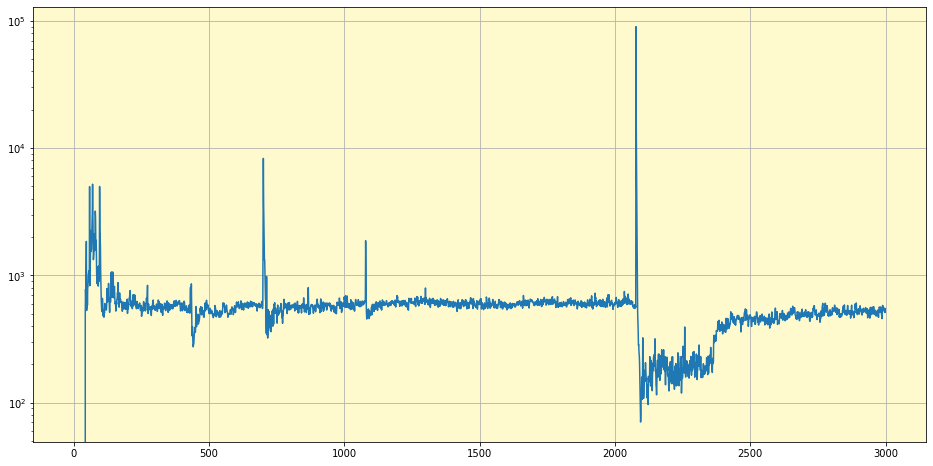

In [16]:
# State Action pairs = Q value convergence
plt.figure(0, figsize=(16,8))
plt.title('Log Scale - Q Value Convergence - state [0,0,0] action (0,2)')
xaxis = np.asarray(range(0, len(agent.states_tracked)))
plt.subplot(111,facecolor='lemonchiffon')
plt.semilogy(xaxis,np.asarray(agent.states_tracked))
plt.grid(True)
plt.show()

In [17]:
Sample_Score_Tracked = [score_tracked[i] for i in range(len(score_tracked)) if (i % 4 == 0)]

In [18]:
print("*********Sample Score Tracked *********\n",Sample_Score_Tracked)

*********Sample Score Tracked *********
 [-102.0, -246.0, -321.0, -274.0, 64.0, -205.0, 79.0, -279.0, -112.0, -7.0, -234.0, -118.0, -371.0, -190.0, -206.0, -380.0, -391.0, 149.0, 24.0, 32.0, -171.0, 2.0, 81.0, 29.0, -524.0, 200.0, -54.0, -157.0, -53.0, -30.0, -160.0, -125.0, -207.0, -292.0, -153.0, 150.0, -337.0, -57.0, -300.0, -211.0, -192.0, -353.0, -97.0, -112.0, -180.0, -377.0, 120.0, -299.0, -164.0, -21.0, -97.0, 154.0, -193.0, -256.0, -52.0, 80.0, -111.0, -36.0, -88.0, -157.0, -511.0, 169.0, -44.0, -56.0, -81.0, 429.0, -8.0, -91.0, -215.0, -382.0, 36.0, 114.0, -216.0, -166.0, -9.0, -74.0, 28.0, -68.0, -310.0, 29.0, -78.0, -180.0, -297.0, -67.0, 86.0, 104.0, 24.0, -100.0, -320.0, -66.0, -75.0, -126.0, 60.0, -211.0, 44.0, -55.0, -44.0, -66.0, -63.0, -18.0, -216.0, -64.0, -350.0, -85.0, -308.0, 46.0, -101.0, 27.0, -138.0, -35.0, -158.0, 45.0, -501.0, 114.0, -139.0, -71.0, 63.0, -110.0, -31.0, -81.0, -237.0, -27.0, -67.0, 32.0, -407.0, -423.0, -66.0, 145.0, 74.0, -76.0, -308.0, 82.0,

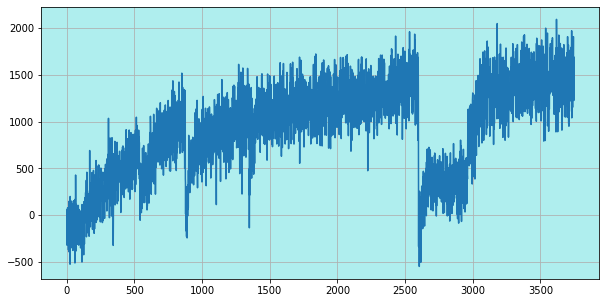

In [19]:
plt.figure(0, figsize=(10,5))
plt.title('Rewards Per Episode')
plt.subplot(111,facecolor='paleturquoise')
xaxis = np.asarray(range(0, len(Sample_Score_Tracked)))
plt.plot(xaxis,np.asarray(Sample_Score_Tracked))
plt.grid(True)
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [20]:
time = np.arange(0,15000)
epsilon = []
for i in range(0,15000):
    epsilon.append(0 + (1 - 0.00001) * np.exp(-0.0003*i))

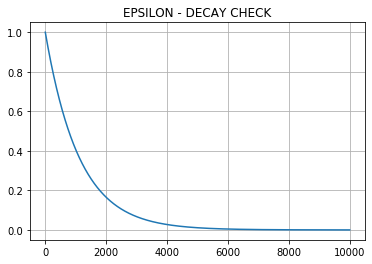

In [21]:
plt.plot(time, epsilon)
plt.title('EPSILON - DECAY CHECK')
plt.grid(True)
plt.show()